CODE BLOCK: 1

In [1]:
import torch
# Torch is the top level PyTorch package in tensor library. Hence, we are importing it first
import torch.nn as nn
# Importing the base class for all neural network modules
import torch.nn.functional as F
# Importing functional class that contains convolutions and other related functions
import torch.optim as optim
# torch.optim is a package implementing various optimization algorithms
from torchvision import datasets, transforms
# torchvision is a package that provides us access to popular datasets, model architectures & image transformations for computer vision
# torchvision.transforms is an interface to give us access to common tranformations for image processing
!pip install torchsummary
# This is collab way to install packages and here we are installing torchsummary
from torchsummary import summary
# Summary provides us insight into model parameters

Defaulting to user installation because normal site-packages is not writeable


CODE BLOCK: 2

In [2]:
# CUDA Available?
cuda = torch.cuda.is_available()
# We are checking with PyTorch whether cuda library is available. This cuda library will help to accelerate execution of the model on the GPU
print("CUDA Available?", cuda)
device = torch.device("cuda" if cuda else "cpu")
# We are storing the result of validation in variable called "device"

CUDA Available? False


CODE BLOCK: 3

In [3]:
# Train data transformations
train_transforms = transforms.Compose([
    # This is the Transform (T) part of the ETL process where we are transforming the data into tensors
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    # It does a crop in the center in a random fashion
    transforms.Resize((28, 28)),
    # resizes the image to 28 x 28
    transforms.RandomRotation((-15., 15.), fill=0),
    # performs a rotation in a random way based on parameters entered
    transforms.ToTensor(),
    # Immediately after downloading the dataset, we are converting it into tensor
    # Converting to Tensor facilitates following: a) It allows porting data to GPU b) It standardizes the values from 0-255 to 0-1
    transforms.Normalize((0.1307,), (0.3081,)),
    # Normalization is done to bring lot of bright or dull images to similar level of brightness of other images
    ])

# Test data transformations
test_transforms = transforms.Compose([
    # This is the Transform (T) part of the ETL process where we are transforming the data into tensors
    transforms.ToTensor(),
    # Immediately after downloading the dataset, we are converting it into tensor
    # Converting to Tensor facilitates following: a) It allows porting data to GPU b) It standardizes the values from 0-255 to 0-1
    transforms.Normalize((0.1307,), (0.3081,))
    # Normalization is done to bring lot of bright or dull images to similar level of brightness of other images
    ])

CODE BLOCK: 4

In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
# The dataset named "MNIST" is being called from within the torchvision available datasets
# MNIST is a dataset containing handwritten digits
# The training part of the dataset is downloaded to ../data location
# This is also the Extract (E) part of the ETL process where we are going to extract the dataset from raw data
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)
# The test part of the dataset is downloaded to ../data location

CODE BLOCK: 5

In [5]:
batch_size = 32
# Batch Size is a tunable parameter that tells us how many images can be sent in parallel to the model. 
# This depends on the available memory and can be increased/decreased accordingly. This is tuned after the model is ran and based on available memory
kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
# trainloader is sort of "for" loop for us which will allow to look at or load a lot of images (~batch_size) at same time
# torch.utils.data.DataLoader wraps a dataset and provides access to the underlying data
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
# test till help to check accuracy of our model

CODE BLOCK: 6

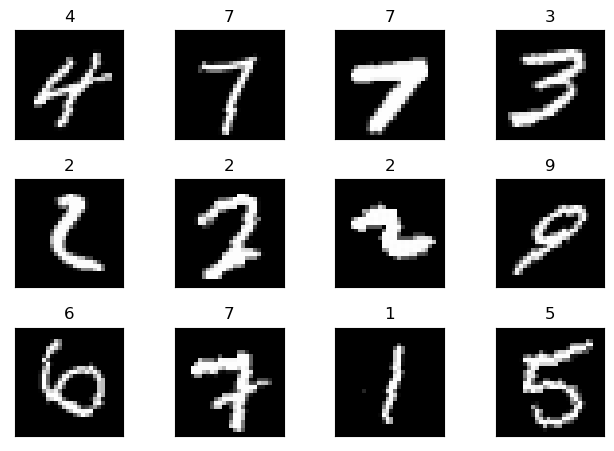

In [6]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [7]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.fc1 = nn.Linear(256*4*4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):                                 # Channel Size | RF | Jump Parameter
        x = F.relu(self.conv1(x))                         # 28 > 26 | 1>3 | 1>1
        x = F.max_pool2d(F.relu(self.conv2(x)),2)         # 26 > 24 > 12 | 3>5>6 | 1>1>2
        x = F.relu(self.conv3(x))                         # 12>10 | 6>10 | 2>2
        x =F.max_pool2d(F.relu(self.conv4(x)),2)          # 10>8>4 | 10>14>16 | 2>2>4
        x = x.view(-1, 4096)                              # 4*4*256 = 4096

        x = F.relu(self.fc1(x))                           # 4*4*256 input layers -> 50 hidden layers

        x = self.fc2(x)                                   # 50 hidden layers -> 10 layers  

        
        return F.log_softmax(x, dim=1)
        # Applies a softmax followed by a logarithm.
        # While mathematically equivalent to log(softmax(x)), doing these two operations separately is slower and numerically unstable. 
        # This function uses an alternative formulation to compute the output and gradient correctly.

CODE BLOCK: 8

In [8]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 8

In [9]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  # here we are using the train component of the model
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    # here above we are looping through each batch represented by batch id (like 4th batch, 5th batch, etc) and data is images of batch and target is the label  
    data, target = data.to(device), target.to(device)
    # since model is being trained on GPU, we need to send data and targets also to GPU. They can't be on CPU
    optimizer.zero_grad()
    # When we do back propagation, the gradients will be stored at one place and we need to initiate gradients as zero to begin withwhich is done in this step
    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    # Computing loss using negative likelyhood loss function. Comparision is made between predicted output with targets
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    # The loss is sent to backpropagation and here the gradients are computed based on the loss
    optimizer.step()
    # Applying the gradients to the parameters
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()
    # here we are involking the evaluation method of the model object
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # Here we are looping through the images and labels in the test dataset
            data, target = data.to(device), target.to(device)
            # since model is being trained on GPU, we need to send data and targets also to GPU. They can't be on CPU
            output = model(data)
            # we are sending model output to output variable
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            # Computing loss using negative likelyhood loss function. Comparision is made between predicted output with targets
            # We are also summing up batch loss
            correct += GetCorrectPredCount(output, target)
            # Summing up the correct predictions

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
     

ModuleNotFoundError: No module named 'tqdm'

CODE BLOCK: 9

In [ ]:
model = Net().to(device)
# Creating an object of the class we created and sending that object to GPU
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# Optimizes using stochastic gradient descent optimization algorithm with learning rate of 0.01 and momentum of 0.9
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.0746 Batch_id=1874 Accuracy=93.77: 100%|██████████| 1875/1875 [00:49<00:00, 37.81it/s]


Test set: Average loss: 0.0386, Accuracy: 9885/10000 (98.85%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.0276 Batch_id=1874 Accuracy=98.15: 100%|██████████| 1875/1875 [00:39<00:00, 47.66it/s]


Test set: Average loss: 0.0277, Accuracy: 9908/10000 (99.08%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.1718 Batch_id=1874 Accuracy=98.61: 100%|██████████| 1875/1875 [00:38<00:00, 48.74it/s]


Test set: Average loss: 0.0340, Accuracy: 9889/10000 (98.89%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0026 Batch_id=1874 Accuracy=98.83: 100%|██████████| 1875/1875 [00:36<00:00, 51.24it/s]


Test set: Average loss: 0.0253, Accuracy: 9914/10000 (99.14%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0075 Batch_id=1874 Accuracy=99.00: 100%|██████████| 1875/1875 [00:36<00:00, 51.10it/s]


Test set: Average loss: 0.0270, Accuracy: 9921/10000 (99.21%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 6


Train: Loss=0.0223 Batch_id=1874 Accuracy=99.42: 100%|██████████| 1875/1875 [00:38<00:00, 48.52it/s]


Test set: Average loss: 0.0183, Accuracy: 9942/10000 (99.42%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 7


Train: Loss=0.0004 Batch_id=1874 Accuracy=99.53: 100%|██████████| 1875/1875 [00:37<00:00, 50.63it/s]


Test set: Average loss: 0.0179, Accuracy: 9941/10000 (99.41%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 8


Train: Loss=0.0096 Batch_id=1874 Accuracy=99.55: 100%|██████████| 1875/1875 [00:36<00:00, 50.93it/s]


Test set: Average loss: 0.0171, Accuracy: 9951/10000 (99.51%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 9


Train: Loss=0.0095 Batch_id=1874 Accuracy=99.54: 100%|██████████| 1875/1875 [00:37<00:00, 50.15it/s]


Test set: Average loss: 0.0171, Accuracy: 9953/10000 (99.53%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 10


Train: Loss=0.0022 Batch_id=1874 Accuracy=99.59: 100%|██████████| 1875/1875 [00:37<00:00, 50.35it/s]


Test set: Average loss: 0.0166, Accuracy: 9948/10000 (99.48%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 11


Train: Loss=0.0036 Batch_id=1874 Accuracy=99.64: 100%|██████████| 1875/1875 [00:36<00:00, 51.96it/s]


Test set: Average loss: 0.0168, Accuracy: 9948/10000 (99.48%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 12


Train: Loss=0.0003 Batch_id=1874 Accuracy=99.59: 100%|██████████| 1875/1875 [00:35<00:00, 53.33it/s]


Test set: Average loss: 0.0168, Accuracy: 9950/10000 (99.50%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 13


Train: Loss=0.0002 Batch_id=1874 Accuracy=99.62: 100%|██████████| 1875/1875 [00:34<00:00, 53.77it/s]


Test set: Average loss: 0.0169, Accuracy: 9949/10000 (99.49%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 14


Train: Loss=0.0015 Batch_id=1874 Accuracy=99.63: 100%|██████████| 1875/1875 [00:36<00:00, 51.24it/s]


Test set: Average loss: 0.0167, Accuracy: 9946/10000 (99.46%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 15


Train: Loss=0.0002 Batch_id=1874 Accuracy=99.61: 100%|██████████| 1875/1875 [00:35<00:00, 53.43it/s]


Test set: Average loss: 0.0167, Accuracy: 9949/10000 (99.49%)

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 16


Train: Loss=0.0003 Batch_id=1874 Accuracy=99.64: 100%|██████████| 1875/1875 [00:36<00:00, 51.69it/s]


Test set: Average loss: 0.0167, Accuracy: 9949/10000 (99.49%)

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 17


Train: Loss=0.0318 Batch_id=1874 Accuracy=99.59: 100%|██████████| 1875/1875 [00:35<00:00, 52.72it/s]


Test set: Average loss: 0.0167, Accuracy: 9948/10000 (99.48%)

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 18


Train: Loss=0.0669 Batch_id=1874 Accuracy=99.62: 100%|██████████| 1875/1875 [00:37<00:00, 50.62it/s]


Test set: Average loss: 0.0168, Accuracy: 9949/10000 (99.49%)

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 19


Train: Loss=0.0002 Batch_id=1874 Accuracy=99.64: 100%|██████████| 1875/1875 [00:36<00:00, 51.25it/s]


Test set: Average loss: 0.0168, Accuracy: 9948/10000 (99.48%)

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 20


Train: Loss=0.0013 Batch_id=1874 Accuracy=99.60: 100%|██████████| 1875/1875 [00:36<00:00, 51.48it/s]


Test set: Average loss: 0.0168, Accuracy: 9948/10000 (99.48%)

Adjusting learning rate of group 0 to 1.0000e-06.


Text(0.5, 1.0, 'Test Accuracy')

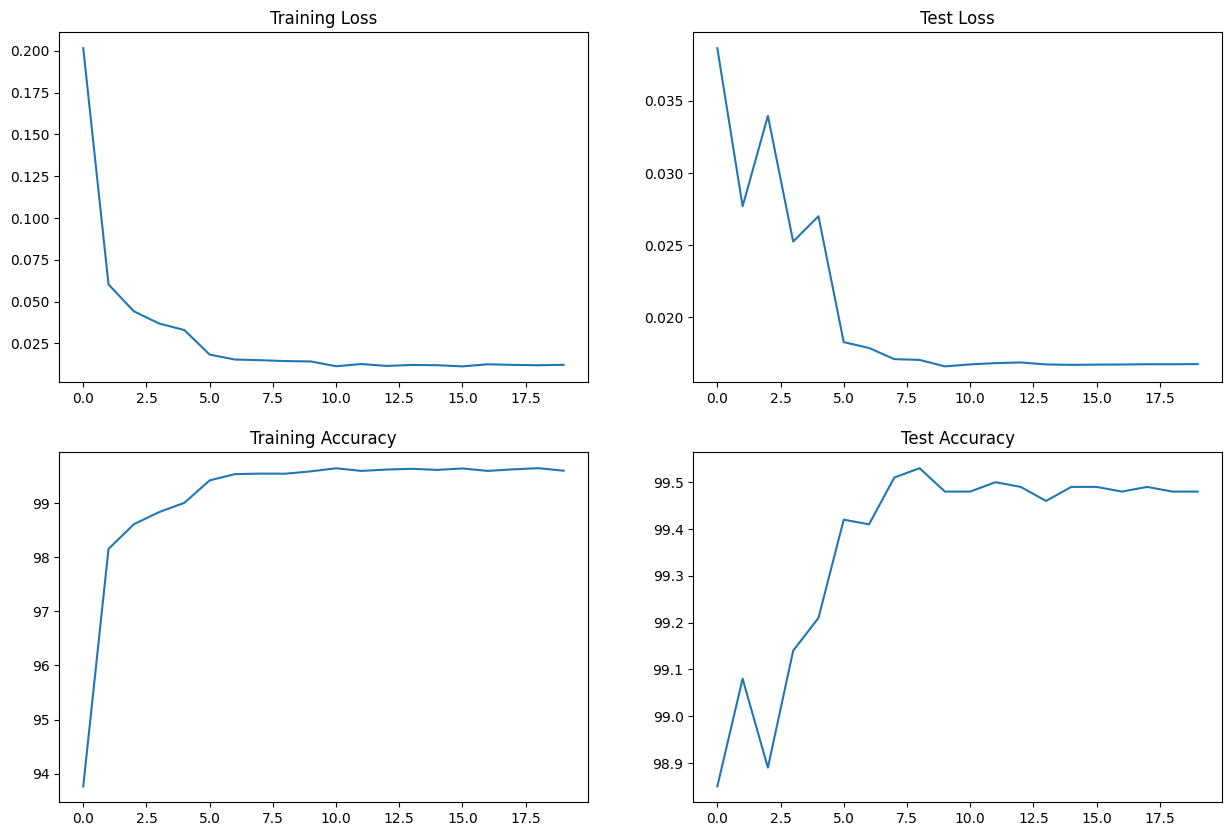

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))
# To know the number of parameters of the model, we are using summary method from PyTorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------
